# Deep Residual Net Example

In [1]:
import tensorflow as tf
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

print("Tensorflow Version: {}".format(tf.version.VERSION))

Tensorflow Version: 2.8.0


In [2]:
# Aux function to create a subblock ReLU-BN as x = relu_bn(x)
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [3]:
# Aux function to create a residual block as x = residual_block(x,downsample=False,filters=16)

def residual_block(x: Tensor,              # input tensor
                   downsample: bool,       # if True increase stride to 2
                   filters: int,           # no. of filters       
                   kernel_size: int = 3    # kernel size, 3x3 by default
                   ) -> Tensor:            # output type should be Tensor

    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:                         # adjust map sizes
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)

    out = Add()([x, y])                    # add shortcut
    out = relu_bn(out)
    return out

In [4]:
# Function that creates the whole ResNet
def create_my_res_net():
    
    inputs = Input(shape=(32, 32, 3))  # to be used with CIFAR-10
    num_filters = 64
    
    # Beginning
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    

    # Four groups of residual blocks
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)

        num_filters *= 2    # increase filters for each group of blocks
    

    # Ending and final prediction
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(10, activation='softmax')(t)
    
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [5]:
model = create_my_res_net() 
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 3)   12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['batch_normalization[0][0]']    
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 64)   0           ['conv2d[0][0]']             

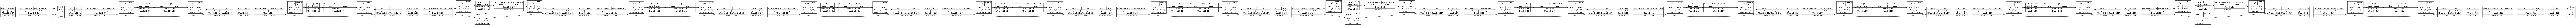

In [6]:
plot_model(model, to_file='model.png', 
           show_shapes=True, show_layer_activations=True,
           rankdir='LR', #TB by default
           dpi=54)

In [7]:
# Input data

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [8]:

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'cifar-10_res_net_30-'+timestr 

checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.system('mkdir {}'.format(checkpoint_dir))

# save model after each epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1
)
tensorboard_callback = TensorBoard(
    log_dir='tensorboard_logs/'+name,
    histogram_freq=1
)

In [9]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=10,
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=128,
    callbacks=[cp_callback, tensorboard_callback]
)

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 1.4779 - accuracy: 0.4696
Epoch 1: saving model to checkpoints/cifar-10_res_net_30-20220222-222355/cp-0001.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20220222-222355/cp-0001.ckpt/assets
391/391 [==============================] - 176s 412ms/step - loss: 1.4779 - accuracy: 0.4696 - val_loss: 1.5501 - val_accuracy: 0.5320
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.9956 - accuracy: 0.6514
Epoch 2: saving model to checkpoints/cifar-10_res_net_30-20220222-222355/cp-0002.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20220222-222355/cp-0002.ckpt/assets
391/391 [==============================] - 159s 407ms/step - loss: 0.9956 - accuracy: 0.6514 - val_loss: 1.4770 - val_accuracy: 0.5888
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.7489 - accuracy: 0.7430
Epoch 3: saving model to checkpoints/cifar-10_res_net_30-2022022

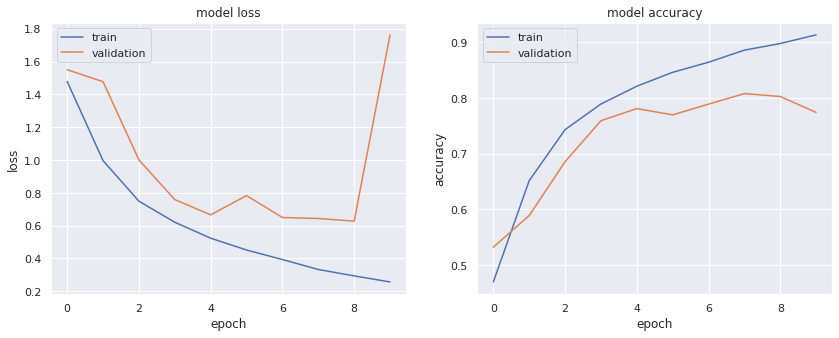

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
plt.figure(figsize=(14,5))
# "Loss"
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# "Accuracy"
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()